# Assignment


In [1]:
import pandas as pd
import geopandas as gpd
import psycopg2
import json
from sqlalchemy import create_engine, text
from sqlalchemy.types import Integer, String
from shapely.geometry import shape
import matplotlib.pyplot as plt

## Clear data

Collate the data in SA2.zip to obtain the SA2code, SA2name data content and gccreated information. And filter out the line where the blank coordinate information is located, and add a placeholder "0" to the content containing the missing value to prevent the future use of this data. Finally, check that all geometry objects in the Geometry column are valid and have no duplicates.

In [2]:
SA2 = gpd.read_file("SA2/SA2_2021_AUST_GDA2020.shp")
columns_to_keep = ['SA2_CODE21', 'SA2_NAME21','GCC_CODE21', 'GCC_NAME21', 'geometry']
SA2 = SA2[columns_to_keep]
# Canonical column name
SA2.rename(columns={'SA2_CODE21': 'sa2_code'}, inplace=True)
SA2.rename(columns={'SA2_NAME21': 'sa2_name'}, inplace=True)
SA2.rename(columns={'GCC_CODE21': 'gcc_code'}, inplace=True)
SA2.rename(columns={'GCC_NAME21': 'gcc_name'}, inplace=True)
SA2.dropna(subset=['geometry'], inplace=True)
SA2.fillna(value=0, inplace=True)
SA2.drop_duplicates(subset=['geometry'], inplace=True)
valid_geom = SA2['geometry'].apply(lambda x: shape(x).is_valid)
SA2 = SA2[valid_geom]

Collate the data in "Stops.txt",some content that was not relevant for later analysis was deleted, leaving the content related to the platforms in the database and their latitude and longitude data.

In [3]:
Stops = pd.read_csv("Stops.txt", delimiter=",")
columns_to_keep = ['stop_id','stop_code','stop_name', 'stop_lat','stop_lon']
Stops = Stops[columns_to_keep]
# Canonical column name
Stops.rename(columns={'stop_lat': 'latitude'}, inplace=True)
Stops.rename(columns={'stop_lon': 'longitude'}, inplace=True)

Collate the data in "Businesses.csv", convert the data content to the corresponding data format,and filtered the data, keeping only data on industry type, sa2 and total number of businesses.And check if the value of SA2 is valid.

In [4]:
Businesses =  pd.read_csv('Businesses.csv')
Businesses['total_businesses'] = Businesses['total_businesses'].astype(int)
columns_to_keep = ['industry_code','industry_name','sa2_code','sa2_name','total_businesses']
Businesses = Businesses[columns_to_keep]
compare = SA2['sa2_code'].astype(int)
Businesses['match'] = Businesses['sa2_code'].isin(compare)
Businesses = Businesses[Businesses['match'] == True].drop(columns=['match'])

After sorting out the data in "PollingPlaces2019.csv", I deleted some column names not related to the later analysis, and deleted the data with blank and duplicate coordinates. For some rows with missing information, I chose to add a 0 as a placeholder, because these data may be related to the following, and reserved some information.

In [5]:
Polls = pd.read_csv("PollingPlaces2019.csv")
Polls.drop_duplicates(subset=['the_geom'], inplace=True)
columns_to_keep = ['polling_place_id','polling_place_name','latitude','longitude']
Polls = Polls[columns_to_keep]
Polls.dropna(subset=['latitude','longitude'], inplace=True)
Polls.fillna(value=0, inplace=True)

Collate the data in "Catchments.zip", combine the three data tables into one data table, because in task2, people from 0-19 years old are combined as "young people", so "CATCH_TYPE", "ADD_DATE", "KINDERGART", "young people", and so on. The "YEAR1-12" columns are all deleted. Only the columns USE_ID, USE_DESC, and geometry are reserved. And filter out the line where the blank coordinate information is located, for some missing information, I choose to add a 0 as a placeholder, because these data may be related to the following, giving some information retention. Finally, check that all geometry objects in the Geometry column are valid and not duplicated, and convert CRS to 7844

In [6]:
School_future = gpd.read_file("Catchments/catchments/catchments_future.shp")
School_primary = gpd.read_file("Catchments/catchments/catchments_primary.shp")
School_secondary = gpd.read_file("Catchments/catchments/catchments_secondary.shp")
merged_schools = gpd.GeoDataFrame(pd.concat([School_future, School_primary, School_secondary], ignore_index=True))
columns_to_keep = ['USE_ID','USE_DESC','geometry']
School = merged_schools[columns_to_keep].copy()
School['USE_ID'] = School['USE_ID'].astype(int)
School.dropna(subset=['geometry'], inplace=True)
School.fillna(value=0, inplace=True)

School.drop_duplicates(subset=['geometry'], inplace=True)
School.drop_duplicates(subset=['USE_ID'], inplace=True)

valid_geom = School['geometry'].apply(lambda x: shape(x).is_valid)
School = School[valid_geom]

School['geometry'] = School['geometry'].to_crs(epsg=7844)

# Canonical column name
School.rename(columns={'USE_ID': 'use_id'}, inplace=True)
School.rename(columns={'USE_DESC': 'use_desc'}, inplace=True)

Collate the data in "Population.csv", convert the data content to the corresponding data format, and add a column named "young_people" to record young people aged 0-19 in the current region.

In [7]:
Population = pd.read_csv("Population.csv")

Population['0-4_people'] = Population['0-4_people'].astype(int)
Population['5-9_people'] = Population['5-9_people'].astype(int)
Population['10-14_people'] = Population['10-14_people'].astype(int)
Population['15-19_people'] = Population['15-19_people'].astype(int)

young_people = Population['0-4_people'] + Population['5-9_people'] + Population['10-14_people'] + Population['15-19_people']
Population['young_people'] = young_people

Population['sa2_code'] = Population['sa2_code'].astype(int)
Population['total_people'] = Population['total_people'].astype(int)
columns_to_keep = ['sa2_code','sa2_name','young_people','total_people']
Population = Population[columns_to_keep]

Collate the data in "incomes.csv", convert the data content into the corresponding data format, clear the abnormal information, and add the column "total_income" to record the total Income in the current region.

In [8]:
Income = pd.read_csv("Income.csv")

contains_np = Income.apply(lambda row: 'np' in row.values, axis=1)
Income = Income[~contains_np]

Income['earners'] = Income['earners'].astype(int)
Income['mean_income'] = Income['mean_income'].astype(int)
total_income = Income['earners'] * Income['mean_income']
Income['total_income'] = total_income
# Canonical column name
Income.rename(columns={'sa2_code21': 'sa2_code'}, inplace=True)


## Import all datasets  PostgreSQL server

Use the pgconnect function to connect to the PostgreSQL server and load the PostGIS extension.

In [9]:
def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

In [10]:
credentials = "Credentials.json"
db, conn = pgconnect(credentials)

Connected successfully.


In [11]:
conn.execute("CREATE EXTENSION IF NOT EXISTS postgis;")

Create the structure of the table, define foreign keys and primary keys to establish associations between different tables.

In [12]:
# SA2
db.execute('''
CREATE TABLE sa2 (
    sa2_code VARCHAR(255) PRIMARY KEY,
    sa2_name VARCHAR(255),
    gcc_code VARCHAR(255),
    gcc_name VARCHAR(255),
    geometry geometry(MULTIPOLYGON, 7844),
    zbusinesses FLOAT,  
    zpolls FLOAT,      
    zstops FLOAT,       
    zschools FLOAT     
)
''')

ProgrammingError: (psycopg2.errors.DuplicateTable) 错误:  关系 "sa2" 已经存在

[SQL: 
CREATE TABLE sa2 (
    sa2_code VARCHAR(255) PRIMARY KEY,
    sa2_name VARCHAR(255),
    gcc_code VARCHAR(255),
    gcc_name VARCHAR(255),
    geometry geometry(MULTIPOLYGON, 7844),
    zbusinesses FLOAT,  
    zpolls FLOAT,      
    zstops FLOAT,       
    zschools FLOAT     
)
]
(Background on this error at: https://sqlalche.me/e/14/f405)

In [14]:
# Stops
db.execute('''
CREATE TABLE stops (
    stop_id VARCHAR(255) PRIMARY KEY,
    stop_code VARCHAR(255),
    stop_name VARCHAR(255),
    latitude FLOAT,
    longitude FLOAT,
    sa2_code VARCHAR(255),
    FOREIGN KEY (sa2_code) REFERENCES SA2(sa2_code)
)
''')

In [15]:
# Businesses
db.execute('''
CREATE TABLE businesses (
    businesses_id SERIAL PRIMARY KEY,
    industry_code VARCHAR(255),
    industry_name VARCHAR(255),
    sa2_code VARCHAR(255),
    sa2_name VARCHAR(255),
    total_businesses INTEGER,
    FOREIGN KEY (sa2_code) REFERENCES SA2(sa2_code)
)
''')

In [16]:
# Polls
db.execute('''
CREATE TABLE polls (
    polling_place_id INTEGER PRIMARY KEY,
    polling_place_name VARCHAR(255),
    latitude FLOAT,
    longitude FLOAT,
    sa2_code VARCHAR(255),
    FOREIGN KEY (sa2_code) REFERENCES SA2(sa2_code)
)
''')

In [17]:
# School
db.execute('''
CREATE TABLE school (
    use_id INTEGER PRIMARY KEY,
    use_desc VARCHAR(255),
    geometry geometry(MULTIPOLYGON, 7844),
    sa2_code VARCHAR(255),
    FOREIGN KEY (sa2_code) REFERENCES SA2(sa2_code)
)
''')

In [18]:
# Population
db.execute('''
CREATE TABLE population (
    sa2_code VARCHAR(255),
    sa2_name VARCHAR(255),
    young_people INTEGER,
    total_people INTEGER,
    PRIMARY KEY (sa2_name),
    FOREIGN KEY (sa2_code) REFERENCES SA2(sa2_code)
)
''')

In [19]:
# Income
db.execute('''
CREATE TABLE income (
    sa2_code VARCHAR(255),
    sa2_name VARCHAR(255),
    earners INTEGER,
    median_age FLOAT,
    median_income FLOAT,
    mean_income FLOAT,
    total_income FLOAT,
    PRIMARY KEY (sa2_name),
    FOREIGN KEY (sa2_code) REFERENCES SA2(sa2_code)
)
''')

In the Businesses, Population, and Income tables, the SA2_code column is defined as a foreign key, which references the SA2_code column in the SA2 table as the primary key. This establishes an association between these tables.

Load the cleaned data to the server one by one.

In [13]:
SA2.to_postgis('sa2', db, index=False,if_exists='append')

UniqueViolation: 错误:  重复键违反唯一约束"sa2_pkey"
DETAIL:  键值"(sa2_code)=(101021007)" 已经存在
CONTEXT:  COPY sa2, line 1


In [13]:
Polls.to_sql('polls', db, index=False, if_exists='append')

IntegrityError: (psycopg2.errors.UniqueViolation) 错误:  重复键违反唯一约束"polls_pkey"
DETAIL:  键值"(polling_place_id)=(58)" 已经存在

[SQL: INSERT INTO polls (polling_place_id, polling_place_name, latitude, longitude) VALUES (%(polling_place_id)s, %(polling_place_name)s, %(latitude)s, %(longitude)s)]
[parameters: ({'polling_place_id': 58, 'polling_place_name': 'Oatley', 'latitude': -33.9847, 'longitude': 151.081}, {'polling_place_id': 392, 'polling_place_name': 'Dharruk', 'latitude': -33.7475, 'longitude': 150.817}, {'polling_place_id': 31, 'polling_place_name': 'Allawah', 'latitude': -33.9767897, 'longitude': 151.1148974}, {'polling_place_id': 67, 'polling_place_name': 'Allawah South', 'latitude': -33.9756, 'longitude': 151.111}, {'polling_place_id': 56500, 'polling_place_name': 'Beverly Hills North (Banks)', 'latitude': -33.9413, 'longitude': 151.075}, {'polling_place_id': 79612, 'polling_place_name': 'Beverly Hills South (Banks)', 'latitude': -33.9528, 'longitude': 151.085}, {'polling_place_id': 46, 'polling_place_name': 'Blakehurst North', 'latitude': -33.9814, 'longitude': 151.113}, {'polling_place_id': 65425, 'polling_place_name': 'BLV Banks PPVC', 'latitude': -33.9674459, 'longitude': 151.1065776}  ... displaying 10 of 2543 total bound parameter sets ...  {'polling_place_id': 31242, 'polling_place_name': 'Welby', 'latitude': -34.4409, 'longitude': 150.424}, {'polling_place_id': 564, 'polling_place_name': 'Windang', 'latitude': -34.5316, 'longitude': 150.866})]
(Background on this error at: https://sqlalche.me/e/14/gkpj)

In [14]:
Population.to_sql('population', db, index=False, if_exists='append')

IntegrityError: (psycopg2.errors.UniqueViolation) 错误:  重复键违反唯一约束"population_pkey"
DETAIL:  键值"(sa2_name)=(Avoca Beach - Copacabana)" 已经存在

[SQL: INSERT INTO population (sa2_code, sa2_name, young_people, total_people) VALUES (%(sa2_code)s, %(sa2_name)s, %(young_people)s, %(total_people)s)]
[parameters: ({'sa2_code': 102011028, 'sa2_name': 'Avoca Beach - Copacabana', 'young_people': 2121, 'total_people': 7530}, {'sa2_code': 102011029, 'sa2_name': 'Box Head - MacMasters Beach', 'young_people': 2471, 'total_people': 11052}, {'sa2_code': 102011030, 'sa2_name': 'Calga - Kulnura', 'young_people': 961, 'total_people': 4748}, {'sa2_code': 102011031, 'sa2_name': 'Erina - Green Point', 'young_people': 3205, 'total_people': 14803}, {'sa2_code': 102011032, 'sa2_name': 'Gosford - Springfield', 'young_people': 4364, 'total_people': 21346}, {'sa2_code': 102011033, 'sa2_name': 'Kariong', 'young_people': 1980, 'total_people': 6518}, {'sa2_code': 102011034, 'sa2_name': 'Kincumber - Picketts Valley', 'young_people': 1778, 'total_people': 7628}, {'sa2_code': 102011035, 'sa2_name': 'Narara', 'young_people': 1966, 'total_people': 7191}  ... displaying 10 of 373 total bound parameter sets ...  {'sa2_code': 128021608, 'sa2_name': 'Loftus - Yarrawarrah', 'young_people': 2073, 'total_people': 7354}, {'sa2_code': 128021609, 'sa2_name': 'Woronora Heights', 'young_people': 965, 'total_people': 3551})]
(Background on this error at: https://sqlalche.me/e/14/gkpj)

In [15]:
Income.to_sql('income', db, index=False, if_exists='append')

IntegrityError: (psycopg2.errors.UniqueViolation) 错误:  重复键违反唯一约束"income_pkey"
DETAIL:  键值"(sa2_name)=(Braidwood)" 已经存在

[SQL: INSERT INTO income (sa2_code, sa2_name, earners, median_age, median_income, mean_income, total_income) VALUES (%(sa2_code)s, %(sa2_name)s, %(earners)s, %(median_age)s, %(median_income)s, %(mean_income)s, %(total_income)s)]
[parameters: ({'sa2_code': 101021007, 'sa2_name': 'Braidwood', 'earners': 2467, 'median_age': '51', 'median_income': '46640', 'mean_income': 68904, 'total_income': 169986168}, {'sa2_code': 101021008, 'sa2_name': 'Karabar', 'earners': 5103, 'median_age': '42', 'median_income': '65564', 'mean_income': 69672, 'total_income': 355536216}, {'sa2_code': 101021009, 'sa2_name': 'Queanbeyan', 'earners': 7028, 'median_age': '39', 'median_income': '63528', 'mean_income': 69174, 'total_income': 486154872}, {'sa2_code': 101021010, 'sa2_name': 'Queanbeyan - East', 'earners': 3398, 'median_age': '39', 'median_income': '66148', 'mean_income': 74162, 'total_income': 252002476}, {'sa2_code': 101021012, 'sa2_name': 'Queanbeyan West - Jerrabomberra', 'earners': 8422, 'median_age': '44', 'median_income': '78630', 'mean_income': 91981, 'total_income': 774663982}, {'sa2_code': 101021610, 'sa2_name': 'Googong', 'earners': 3555, 'median_age': '37', 'median_income': '86579', 'mean_income': 93292, 'total_income': 331653060}, {'sa2_code': 101021611, 'sa2_name': 'Queanbeyan Surrounds', 'earners': 10647, 'median_age': '47', 'median_income': '72491', 'mean_income': 86714, 'total_income': 923243958}, {'sa2_code': 101031013, 'sa2_name': 'Bombala', 'earners': 1399, 'median_age': '48', 'median_income': '49960', 'mean_income': 57429, 'total_income': 80343171}  ... displaying 10 of 635 total bound parameter sets ...  {'sa2_code': 128021608, 'sa2_name': 'Loftus - Yarrawarrah', 'earners': 4424, 'median_age': '45', 'median_income': '63087', 'mean_income': 76440, 'total_income': 338170560}, {'sa2_code': 128021609, 'sa2_name': 'Woronora Heights', 'earners': 2491, 'median_age': '47', 'median_income': '65460', 'mean_income': 82717, 'total_income': 206048047})]
(Background on this error at: https://sqlalche.me/e/14/gkpj)

In [16]:
Stops.to_sql('stops', db, index=False, if_exists='append')

IntegrityError: (psycopg2.errors.UniqueViolation) 错误:  重复键违反唯一约束"stops_pkey"
DETAIL:  键值"(stop_id)=(200039)" 已经存在

[SQL: INSERT INTO stops (stop_id, stop_code, stop_name, latitude, longitude) VALUES (%(stop_id)s, %(stop_code)s, %(stop_name)s, %(latitude)s, %(longitude)s)]
[parameters: ({'stop_id': '200039', 'stop_code': 200039.0, 'stop_name': 'Central Station, Eddy Av, Stand A', 'latitude': -33.8822064874687, 'longitude': 151.20666465471}, {'stop_id': '200054', 'stop_code': 200054.0, 'stop_name': 'Central Station, Eddy Av, Stand D', 'latitude': -33.8820421431408, 'longitude': 151.20699145565}, {'stop_id': '200060', 'stop_code': None, 'stop_name': 'Central Station', 'latitude': -33.8840842535493, 'longitude': 151.206292455081}, {'stop_id': '201510', 'stop_code': None, 'stop_name': 'Redfern Station', 'latitude': -33.8916900512711, 'longitude': 151.198866071817}, {'stop_id': '201646', 'stop_code': 201646.0, 'stop_name': 'Redfern Station, Gibbons St, Stand B', 'latitude': -33.8933293130144, 'longitude': 151.198881722942}, {'stop_id': '204230', 'stop_code': 204230.0, 'stop_name': 'St Peters Station, King St', 'latitude': -33.9063142029908, 'longitude': 151.181117167927}, {'stop_id': '204311', 'stop_code': 204311.0, 'stop_name': 'King St Opp St Peters Station', 'latitude': -33.9064227004899, 'longitude': 151.181371008764}, {'stop_id': '204313', 'stop_code': 204313.0, 'stop_name': 'Erskineville Rd At Charles St', 'latitude': -33.8997132561368, 'longitude': 151.184727384289}  ... displaying 10 of 114718 total bound parameter sets ...  {'stop_id': '21501', 'stop_code': 21501.0, 'stop_name': 'Parramatta Wharf', 'latitude': -33.8139042429414, 'longitude': 151.010576673346}, {'stop_id': '2150112', 'stop_code': None, 'stop_name': 'Parramatta Wharf', 'latitude': -33.8139523874985, 'longitude': 151.010481768913})]
(Background on this error at: https://sqlalche.me/e/14/gkpj)

In [17]:
School.to_postgis('school', db, index=False, if_exists='append')

UniqueViolation: 错误:  重复键违反唯一约束"school_pkey"
DETAIL:  键值"(use_id)=(8416)" 已经存在
CONTEXT:  COPY school, line 1


In [14]:
Businesses.to_sql('businesses', db, index=False, if_exists='append')

198

Next, the corresponding geometry information is generated by obtaining the latitude and longitude from the site table, poll table, and school table, and the corresponding sa2_code is obtained by matching the coordinate information with the geometry in the sa2 table. If sa2 does not match the content, the data is deleted.

In [19]:
db.execute('''
ALTER TABLE Stops
ADD COLUMN geom GEOMETRY(Point, 4326);
UPDATE Stops
SET geom = ST_SetSRID(ST_MakePoint(longitude, latitude), 4326);
ALTER TABLE Stops
ADD COLUMN geometry_7844 GEOMETRY(Point, 7844);
UPDATE Stops
SET geometry_7844 = ST_Transform(geom, 7844);

UPDATE Stops s
SET sa2_code = sa2.sa2_code
FROM SA2 sa2
WHERE ST_Within(s.geometry_7844, sa2.geometry);

DELETE FROM Stops
WHERE sa2_code IS NULL;

ALTER TABLE Stops
DROP COLUMN geom;
ALTER TABLE Stops
DROP COLUMN geometry_7844;
''')

In [20]:
db.execute('''
ALTER TABLE Polls
ADD COLUMN geom GEOMETRY(Point, 4326);
UPDATE Polls
SET geom = ST_SetSRID(ST_MakePoint(longitude, latitude), 4326);
ALTER TABLE Polls
ADD COLUMN geometry_7844 GEOMETRY(Point, 7844);
UPDATE Polls
SET geometry_7844 = ST_Transform(geom, 7844);

UPDATE Polls p
SET sa2_code = sa2.sa2_code
FROM SA2 sa2
WHERE ST_Within(p.geometry_7844, sa2.geometry);

DELETE FROM Polls
WHERE sa2_code IS NULL;

ALTER TABLE Polls
DROP COLUMN geom;
ALTER TABLE Polls
DROP COLUMN geometry_7844;
''')

In [21]:
db.execute('''
UPDATE School s
SET SA2_code = sa2.SA2_code
FROM SA2 sa2
WHERE ST_Within(s.geometry, sa2.geometry);

DELETE FROM School
WHERE sa2_code IS NULL;
''')

# Calculate the Zbusiness

Extract data from database  only calculate scores for SA2 regions with a population of at least 100，which industries are "Accommodation and Food Services" and "Information Media and Telecommunications". Then calculate the total number of businesses in these industries in each SA2 region. What's more, How busy Accommodation and Food Services are is a direct indicator of how attractive and active an area is, The active degree of Information Media and Telecommunications can reflect the degree of regional technology and information mobility, and is an indicator of the vitality of modern cities.

After that, the z-score formula is given by $z = \frac{X - \mu}{\sigma}$, where $X$ is the value, $\mu$ is the mean, and $\sigma$ is the standard deviation.

The window function OVER() is used here to calculate the mean and standard deviation of all selected data

In [15]:
db.execute('''
CREATE TEMP TABLE temp_zbusinesses (
    sa2_code VARCHAR(255),
    zbusiness FLOAT
);
INSERT INTO temp_zbusinesses (sa2_code, zbusiness)
WITH selected AS (
    SELECT
        sa2.sa2_code,
        COALESCE(SUM(b.total_businesses), 0) AS selected_industries
    FROM
        sa2
    LEFT JOIN businesses b ON sa2.sa2_code = b.sa2_code 
        AND b.industry_name IN ('Accommodation and Food Services', 'Information Media and Telecommunications')
    LEFT JOIN Population pop ON sa2.sa2_code = pop.sa2_code
    WHERE
        pop.total_people >= 100 OR pop.total_people IS NULL
    GROUP BY 
        sa2.sa2_code
),
stats AS (
    SELECT
        sa2_code,
        selected_industries,
        AVG(selected_industries) OVER() AS avg_industries,
        STDDEV(selected_industries) OVER() AS stddev_industries
    FROM selected
)
SELECT
    sa2_code,
    CASE
        WHEN stddev_industries = 0 THEN 0
        ELSE (selected_industries - avg_industries) / stddev_industries
    END AS zbusiness
FROM stats;
UPDATE sa2
SET zbusinesses = (
    SELECT zbusiness
    FROM temp_zbusinesses
    WHERE temp_zbusinesses.sa2_code = sa2.sa2_code
);
DROP TABLE IF EXISTS temp_zbusinesses;
''')

In [16]:
zbusiness = db.execute('''
SELECT sa2_code, sa2_name, zbusinesses
FROM sa2;
''')

for row in zbusiness:
    sa2_code = row[0]
    sa2_name = row[1]
    zbusiness = row[2]
    print(f"SA2 Code: {sa2_code}, SA2 Name: {sa2_name}, Z-Business: {zbusiness}")

SA2 Code: 301011001, SA2 Name: Alexandra Hills, Z-Business: -0.3285028586242801
SA2 Code: 101021007, SA2 Name: Braidwood, Z-Business: 0.2518983473335583
SA2 Code: 101021010, SA2 Name: Queanbeyan - East, Z-Business: 0.09826273399177757
SA2 Code: 101061544, SA2 Name: Young Surrounds, Z-Business: 0.20068647621963143
SA2 Code: 102011028, SA2 Name: Avoca Beach - Copacabana, Z-Business: 0.45674583178926603
SA2 Code: 101021008, SA2 Name: Karabar, Z-Business: -0.05537287935000319
SA2 Code: 101021009, SA2 Name: Queanbeyan, Z-Business: 0.900582048109966
SA2 Code: 101021611, SA2 Name: Queanbeyan Surrounds, Z-Business: 0.7640170584728275
SA2 Code: 101031013, SA2 Name: Bombala, Z-Business: -0.0895141267592878
SA2 Code: 101031014, SA2 Name: Cooma, Z-Business: 0.7469464347681852
SA2 Code: 101031015, SA2 Name: Cooma Surrounds, Z-Business: 0.1665452288103468
SA2 Code: 101031016, SA2 Name: Jindabyne - Berridale, Z-Business: 3.1709750008273927
SA2 Code: 101041017, SA2 Name: Batemans Bay, Z-Business: 0.79

# Calculate the Zstops

Zstops used to quantify the standardised deviation of the number of public transport stops in each SA2 region relative to the average number of stops throughout the Sydney region

the z-score formula is given by $z = \frac{X - \mu}{\sigma}$, where $X$ is the value, $\mu$ is the mean, and $\sigma$ is the standard deviation.

The window function OVER() is used here to calculate the mean and standard deviation of all selected data

In [17]:
db.execute('''
CREATE TEMP TABLE temp_zstops (
    sa2_code VARCHAR(255),
    zstop FLOAT
);
INSERT INTO temp_zstops (sa2_code, zstop)
WITH stop_counts AS (
    SELECT
        sa2.sa2_code,
        COALESCE(COUNT(s.stop_id), 0) AS total_stops
    FROM 
        sa2
    LEFT JOIN stops s ON sa2.sa2_code = s.sa2_code
    LEFT JOIN Population p ON sa2.sa2_code = p.sa2_code
    WHERE p.total_people >= 100 OR p.total_people IS NULL
    GROUP BY sa2.sa2_code
),
stats AS (
    SELECT
        sa2_code,
        total_stops,
        AVG(total_stops) OVER() AS avg_stops,
        STDDEV(total_stops) OVER() AS stddev_stops
    FROM stop_counts
)
SELECT
    sa2_code,
    CASE
        WHEN stddev_stops = 0 THEN 0
        ELSE (total_stops - avg_stops) / stddev_stops
    END AS zstop
FROM stats;
UPDATE sa2
SET zstops = (
    SELECT zstop
    FROM temp_zstops
    WHERE temp_zstops.sa2_code = sa2.sa2_code
);
DROP TABLE IF EXISTS temp_zstops;

''')

In [18]:
zstop = db.execute('''
SELECT sa2_code, zstops
FROM sa2;
''')

for row in zstop:
    sa2_code = row[0]
    zstop = row[1]
    print(f"SA2 Code: {sa2_code}, Z-stop: {zstop}")

SA2 Code: 301011001, Z-stop: -0.3907872277928761
SA2 Code: 101021007, Z-stop: 3.1771898485833443
SA2 Code: 101021010, Z-stop: 0.34453357483266817
SA2 Code: 101061544, Z-stop: 0.07714419205974296
SA2 Code: 102011028, Z-stop: 0.6704143850871708
SA2 Code: 101021611, Z-stop: 4.230035543251737
SA2 Code: 101031013, Z-stop: -0.3573635549462605
SA2 Code: 101031014, Z-stop: 0.1105678649063586
SA2 Code: 101031015, Z-stop: -0.3406517185229527
SA2 Code: 101031016, Z-stop: -0.3239398820996448
SA2 Code: 101041017, Z-stop: 0.010296846366511663
SA2 Code: 101041018, Z-stop: 0.00194092815485775
SA2 Code: 101041019, Z-stop: 3.035139238985228
SA2 Code: 101041020, Z-stop: 6.151896731932137
SA2 Code: 317011447, Z-stop: -0.3907872277928761
SA2 Code: 101041021, Z-stop: -0.19024519071318222
SA2 Code: 101041022, Z-stop: -0.3907872277928761
SA2 Code: 101041023, Z-stop: 0.5283637754890542
SA2 Code: 101051540, Z-stop: 0.169059292387936
SA2 Code: 101061541, Z-stop: -0.06490641753837355
SA2 Code: 101061542, Z-stop: 

# Calculate the Zpolls

Zpolls assess the standard deviation of the number of polling stations in each SA2 region from the average of the entire dataset.

the z-score formula is given by $z = \frac{X - \mu}{\sigma}$, where $X$ is the value, $\mu$ is the mean, and $\sigma$ is the standard deviation.

The window function OVER() is used here to calculate the mean and standard deviation of all selected data

In [19]:
db.execute('''
CREATE TEMP TABLE temp_zpolls (
    sa2_code VARCHAR(255),
    zpolls FLOAT
);

INSERT INTO temp_zpolls (sa2_code, zpolls)
WITH poll_counts AS (
    SELECT
        sa2.sa2_code,
        COALESCE(COUNT(p.polling_place_id), 0) AS total_polls
    FROM 
        sa2
    LEFT JOIN polls p ON sa2.sa2_code = p.sa2_code
    LEFT JOIN Population pop ON sa2.sa2_code = pop.sa2_code
    WHERE pop.total_people >= 100 OR pop.total_people IS NULL
    GROUP BY sa2.sa2_code
),
stats AS (
    SELECT
        sa2_code,
        total_polls,
        AVG(total_polls) OVER() AS avg_polls,
        STDDEV(total_polls) OVER() AS stddev_polls
    FROM poll_counts
)
SELECT
    sa2_code,
    CASE
        WHEN stddev_polls = 0 THEN 0
        ELSE (total_polls - avg_polls) / stddev_polls
    END AS zpolls
FROM stats;

UPDATE sa2
SET zpolls = (
    SELECT zpolls
    FROM temp_zpolls
    WHERE temp_zpolls.sa2_code = sa2.sa2_code
);

DROP TABLE IF EXISTS temp_zpolls;
''')

In [20]:
zpoll = db.execute('''
SELECT sa2_code, zpolls
FROM sa2;
''')

for row in zpoll:
    sa2_code = row[0]
    zpoll = row[1]
    print(f"SA2 Code: {sa2_code}, Z-poll: {zpoll}")

SA2 Code: 301011001, Z-poll: -0.4909422388599738
SA2 Code: 101021007, Z-poll: 0.9239219937931501
SA2 Code: 101021010, Z-poll: -0.019320827975599145
SA2 Code: 101061544, Z-poll: 2.810407637330649
SA2 Code: 102011028, Z-poll: 0.4523005829087755
SA2 Code: 101021611, Z-poll: 2.338786226446274
SA2 Code: 101031013, Z-poll: 0.4523005829087755
SA2 Code: 101031014, Z-poll: 0.9239219937931501
SA2 Code: 101031015, Z-poll: 0.9239219937931501
SA2 Code: 101031016, Z-poll: 2.338786226446274
SA2 Code: 101041017, Z-poll: 0.9239219937931501
SA2 Code: 101041018, Z-poll: 0.4523005829087755
SA2 Code: 101041019, Z-poll: 1.3955434046775248
SA2 Code: 101041020, Z-poll: 3.753650459099398
SA2 Code: 317011447, Z-poll: -0.4909422388599738
SA2 Code: 101041021, Z-poll: 0.4523005829087755
SA2 Code: 101041022, Z-poll: -0.4909422388599738
SA2 Code: 101041023, Z-poll: -0.019320827975599145
SA2 Code: 101051540, Z-poll: 4.225271869983772
SA2 Code: 101061541, Z-poll: 0.9239219937931501
SA2 Code: 101061542, Z-poll: 4.69689

# Calculate the Zschools

Zschools uses a standardised approach to measure where the number of school catchments in each region compares to the average for the entire Sydney region. This can help identify which regions are relatively rich in educational resources and which may need more attention and resource input.

the z-score formula is given by $z = \frac{X - \mu}{\sigma}$, where $X$ is the value, $\mu$ is the mean, and $\sigma$ is the standard deviation.

The window function OVER() is used here to calculate the mean and standard deviation of all selected data

In [21]:
db.execute('''
CREATE TEMP TABLE temp_zschools (
    sa2_code VARCHAR(255),
    zschools FLOAT
);

INSERT INTO temp_zschools (sa2_code, zschools)
WITH school_counts AS (
    SELECT 
        sa2.sa2_code, 
        COALESCE(COUNT(s.use_id), 0) AS total_schools
    FROM 
        sa2
    LEFT JOIN school s ON sa2.sa2_code = s.sa2_code
    LEFT JOIN Population p ON sa2.sa2_code = p.sa2_code
    WHERE p.total_people >= 100 OR p.total_people IS NULL
    GROUP BY
        sa2.sa2_code
),
stats AS (
    SELECT
        sa2_code,
        total_schools,
        AVG(total_schools) OVER() AS avg_schools,
        STDDEV(total_schools) OVER() AS stddev_schools
    FROM school_counts
)
SELECT
    sa2_code,
    CASE
        WHEN stddev_schools = 0 THEN 0
        ELSE (total_schools - avg_schools) / stddev_schools
    END AS zschools
FROM stats;

UPDATE sa2
SET zschools = (
    SELECT zschools
    FROM temp_zschools
    WHERE temp_zschools.sa2_code = sa2.sa2_code
);

DROP TABLE IF EXISTS temp_zschools;
''')

In [22]:
zschools = db.execute('''
SELECT sa2_code, zschools
FROM sa2;
''')

for row in zschools:
    sa2_code = row[0]
    zschool = row[1]
    print(f"SA2 Code: {sa2_code}, Z-school: {zschool}")

SA2 Code: 301011001, Z-school: -0.13429495002999384
SA2 Code: 101021007, Z-school: -0.13429495002999384
SA2 Code: 101021010, Z-school: -0.13429495002999384
SA2 Code: 101061544, Z-school: -0.13429495002999384
SA2 Code: 102011028, Z-school: -0.13429495002999384
SA2 Code: 101021611, Z-school: -0.13429495002999384
SA2 Code: 101031013, Z-school: -0.13429495002999384
SA2 Code: 101031014, Z-school: -0.13429495002999384
SA2 Code: 101031015, Z-school: -0.13429495002999384
SA2 Code: 101031016, Z-school: -0.13429495002999384
SA2 Code: 101041017, Z-school: -0.13429495002999384
SA2 Code: 101041018, Z-school: -0.13429495002999384
SA2 Code: 101041019, Z-school: -0.13429495002999384
SA2 Code: 101041020, Z-school: -0.13429495002999384
SA2 Code: 317011447, Z-school: -0.13429495002999384
SA2 Code: 101041021, Z-school: -0.13429495002999384
SA2 Code: 101041022, Z-school: -0.13429495002999384
SA2 Code: 101041023, Z-school: -0.13429495002999384
SA2 Code: 101051540, Z-school: 6.555786132076434
SA2 Code: 10106

# Calculate the Sigmoid function

Calculate the resource richness score of each community through the Sigmoid function.

In [23]:
db.execute('''
ALTER TABLE sa2 ADD COLUMN score FLOAT;
UPDATE sa2
SET score = 1.0 / (1.0 + EXP(-(COALESCE(zbusinesses, 0) + COALESCE(zstops, 0) + COALESCE(zpolls, 0) + COALESCE(zschools, 0))));

''')


In [25]:
score = db.execute('''
SELECT sa2_code, score
FROM sa2;
''')

for row in score:
    sa2_code = row[0]
    score = row[1]
    print(f"SA2 Code: {sa2_code}, score: {score}")

SA2 Code: 301011001, score: 0.20676653562166009
SA2 Code: 701021017, score: 0.20676653562166009
SA2 Code: 120021675, score: 0.9976309787531755
SA2 Code: 101021007, score: 0.9854959234631291
SA2 Code: 101021010, score: 0.5717955014824018
SA2 Code: 101061544, score: 0.9504495318616701
SA2 Code: 102011028, score: 0.8092533384348713
SA2 Code: 125031483, score: 0.9917885974008945
SA2 Code: 125031713, score: 0.9823007608271986
SA2 Code: 119031664, score: 0.9917751940969003
SA2 Code: 125031714, score: 0.9868946587865611
SA2 Code: 101021611, score: 0.9992528848781765
SA2 Code: 101031013, score: 0.4678265036051219
SA2 Code: 101031014, score: 0.8385043204346005
SA2 Code: 101031015, score: 0.6491990842385644
SA2 Code: 101031016, score: 0.993641136182613
SA2 Code: 101041017, score: 0.8317501748766947
SA2 Code: 101041018, score: 0.650913445715926
SA2 Code: 101041019, score: 0.9918725338493943
SA2 Code: 101041020, score: 0.9999592699511823
SA2 Code: 317011447, score: 0.20676653562166009
SA2 Code: 10

##  Create a scatter plot by score and region

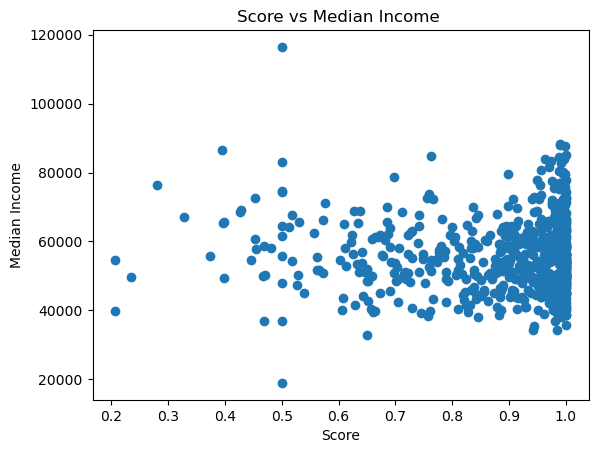

In [69]:
cursor = db.execute('''
SELECT sa2.sa2_name, sa2.score, income.median_income
FROM sa2
JOIN income ON sa2.sa2_code = income.sa2_code;
''')
data = pd.DataFrame(cursor.fetchall(), columns=["sa2_name", "score", "median_income"])
plt.scatter(data["score"], data["median_income"])
plt.xlabel("Score")
plt.ylabel("Median Income")
plt.title("Score vs Median Income ")
plt.show()

# Part 3

For team member Fan Bo, I got the data from opendata about the rest area in New South China State, which is a data group containing spatial data. For this data, I first clear it until only a few columns about "bustling" information and the spatial coordinates of each rest area remain.

In [44]:
rest_area = pd.read_csv('nsw_rest_area.csv')
columns_to_keep = ['rest_area_name', 'rest_area_number','latitude','longitude']
rest_area = rest_area[columns_to_keep]
# Canonical column name
rest_area.rename(columns={'rest_area_name': 'rest_name'}, inplace=True)
rest_area.rename(columns={'rest_area_number': 'rest_id'}, inplace=True)

I then created a new rest table in the data server, including the rest area name and spatial location. The primary key for this table is the rest_id column, and the foreign key is sa2_code to associate with the sa2 table.

In [45]:
# parking
db.execute('''
CREATE TABLE rest (
    rest_name VARCHAR(255),
    rest_id VARCHAR(255) PRIMARY KEY,
    latitude FLOAT,
    longitude FLOAT,
    sa2_code VARCHAR(255),
    FOREIGN KEY (sa2_code) REFERENCES SA2(sa2_code)
)
''')

In [46]:
rest_area.to_sql('rest', db, index=False, if_exists='append')

822

For sa2code in the rest table, I first created a temporary geom column to keep the coordinates, and then changed the EPSG to 7844, which is consistent with the sa2 table, and saved it to the geometry column. Finally, this column is matched against the geometry in sa2 to find the corresponding sa2code.

In [47]:
db.execute('''
ALTER TABLE rest
ADD COLUMN geom GEOMETRY(Point, 4326);
UPDATE rest
SET geom = ST_SetSRID(ST_MakePoint(longitude, latitude), 4326);
ALTER TABLE rest
ADD COLUMN geometry GEOMETRY(Point, 7844);
UPDATE rest
SET geometry = ST_Transform(geom, 7844);

UPDATE rest s
SET sa2_code = sa2.sa2_code
FROM SA2 sa2
WHERE ST_Within(s.geometry, sa2.geometry);

DELETE FROM rest
WHERE sa2_code IS NULL;

ALTER TABLE rest
DROP COLUMN geom;
''')

The Zrest values for each sa2 region in New South Wales were then calculated using the same method ($z = \frac{X - \mu}{\sigma}$, where $X$ is the value, $\mu$ is the mean, and $\sigma$ is the standard deviation.) as for task2.

This new Zrest value is then added to the Score formula to calculate the S-values for these regions

Finally, I created a new spatial index to show that in NSW, the color of each area deepens as the number of rest areas increases.

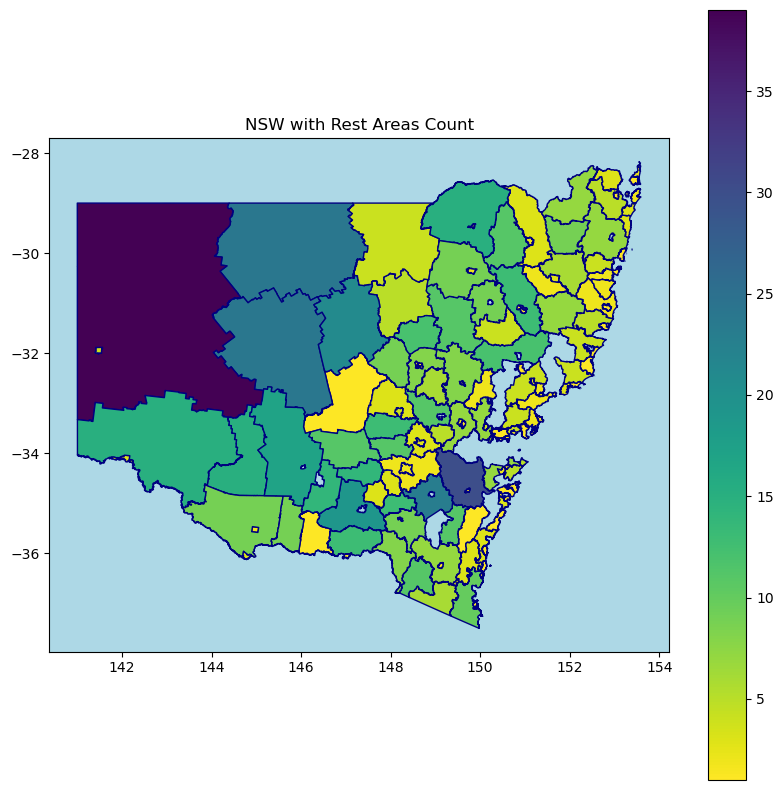

In [48]:
conn.execute("CREATE INDEX rest_geometry_idx ON rest USING GIST(geometry);")

rest_gdf = gpd.read_postgis("SELECT * FROM rest", conn, geom_col='geometry')

sa2_rest_counts = rest_gdf.groupby('sa2_code').size().reset_index(name='rest_count')

sa2_gdf = gpd.read_postgis("SELECT * FROM sa2", conn, geom_col='geometry')
sa2_gdf = sa2_gdf.merge(sa2_rest_counts, on='sa2_code', how='left')

fig, ax = plt.subplots(figsize=(10, 10))
sa2_gdf.plot(ax=ax, column='rest_count', cmap='viridis_r', edgecolor='navy', legend=True)
ax.set_facecolor('lightblue')
plt.title('NSW with Rest Areas Count')
plt.show()

# Part3.3

### Street lighting is an important community asset and can help our communities feel safer. The more public lighting there is, the more people live in the place and the more developed it is.

In [60]:
street_light = pd.read_csv('nsw-street-light-locations.csv')

columns_to_keep = ['Equipment', 'Longitude', 'Latitude']
street_light = street_light[columns_to_keep]

street_light.rename(columns={'Equipment': 'light_id', 'Longitude': 'longitude', 'Latitude': 'latitude'}, inplace=True)

print(street_light.head())

     light_id   longitude   latitude
0  1000935675  151.206061 -33.863291
1  1000935677  151.205586 -33.863277
2  1000935683  151.205653 -33.863438
3  1000935715  151.204891 -33.865020
4  1000935717  151.204867 -33.864823


In [61]:
#light
db.execute('''
CREATE TABLE streetlights (
    longitude FLOAT,
    latitude FLOAT,
    light_id VARCHAR(255) PRIMARY KEY,
    sa2_code VARCHAR(255),
    FOREIGN KEY (sa2_code) REFERENCES SA2(sa2_code)
);

''')

In [62]:
street_light.to_sql('streetlights', db, index=False, if_exists='append')

509

In [63]:
db.execute('''
ALTER TABLE streetlights
ADD COLUMN geom GEOMETRY(Point, 4326);

UPDATE streetlights
SET geom = ST_SetSRID(ST_MakePoint(longitude, latitude), 4326);

ALTER TABLE streetlights
ADD COLUMN geometry GEOMETRY(Point, 7844);

UPDATE streetlights
SET geometry = ST_Transform(geom, 7844);

UPDATE streetlights s
SET sa2_code = sa2.sa2_code
FROM SA2 sa2
WHERE ST_Within(s.geometry, sa2.geometry);

DELETE FROM streetlights
WHERE sa2_code IS NULL;

ALTER TABLE streetlights
DROP COLUMN geom;
''')

In [64]:
db.execute('''
CREATE INDEX idx_streetlights_sa2_code ON streetlights(sa2_code);
CREATE INDEX idx_sa2_sa2_code ON sa2(sa2_code);
CREATE INDEX idx_population_sa2_code ON population(sa2_code);

ALTER TABLE sa2 ADD COLUMN zstreetlights FLOAT;

CREATE TEMP TABLE sa2_population_gt_100 AS
    SELECT sa2_code
    FROM population
    GROUP BY sa2_code
    HAVING SUM(total_people) > 100;

CREATE TEMP TABLE streetlight_counts AS
    SELECT sa2_code, COUNT(*) AS streetlight_count
    FROM streetlights
    WHERE sa2_code IN (SELECT sa2_code FROM sa2_population_gt_100)
    GROUP BY sa2_code;
    
CREATE TEMP TABLE stats AS
    SELECT AVG(streetlight_count) AS avg_streetlight_count, STDDEV(streetlight_count) AS stddev_streetlight_count
    FROM streetlight_counts;

UPDATE sa2
SET zstreetlights = (sc.streetlight_count - s.avg_streetlight_count) / s.stddev_streetlight_count
FROM streetlight_counts sc
CROSS JOIN stats s
WHERE sa2.sa2_code = sc.sa2_code;

DROP TABLE IF EXISTS sa2_population_gt_100;
DROP TABLE IF EXISTS streetlight_counts;
DROP TABLE IF EXISTS stats;

''')

In [68]:
db.execute('''
ALTER TABLE streetlights
ADD COLUMN score FLOAT;

UPDATE streetlights
SET score = 1.0 / (1.0 + EXP(-(
    SELECT COALESCE(zbusinesses, 0) + COALESCE(zstops, 0) + COALESCE(zpolls, 0) + COALESCE(zschools, 0) + COALESCE(zstreetlights, 0)
    FROM sa2
    WHERE sa2.sa2_code = streetlights.sa2_code
)));
''')